In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
zip_path = "/content/drive/MyDrive/cifar10_images.zip"
extract_path = "/content/cifar10_images"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
DATASET_PATH = "/content/cifar10_images/cifar10_images"
PATCH_SIZE = 4
STRIDE = 4
NUM_CLASSES = 10
NUM_EPOCHS = 50
WARMUP_EPOCHS = 5
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-2
BATCH_SIZE = 64
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_accuracies, test_accuracies = [], []

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,) * 3, (0.5,) * 3)
])

In [ ]:
train_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "train"), transform=train_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATASET_PATH, "test"), transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
def patching(images, patch_size=PATCH_SIZE, stride=STRIDE):
    patches = images.unfold(2, patch_size, stride).unfold(3, patch_size, stride)
    patches = patches.permute(0, 2, 3, 1, 4, 5)
    return patches.reshape(patches.size(0), -1, patch_size * patch_size * 3)


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, dim, num_heads):
        super().__init__()
        self.dim = dim
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.qkv_proj = nn.Linear(dim, dim * 3)
        self.out_proj = nn.Linear(dim, dim)
        self.scale = self.head_dim ** -0.5

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv_proj(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = torch.softmax(attn_scores, dim=-1)
        out = torch.matmul(attn, v).permute(0, 2, 1, 3).reshape(B, N, D)
        return self.out_proj(out)

class TransformerBlock(nn.Module):
    def __init__(self, dim, heads=8, mlp_dim=256):
        super().__init__()
        self.attn = MultiHeadAttention(dim, heads)
        self.ln1 = nn.LayerNorm(dim)
        self.ln2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )

    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

class SimpleViT(nn.Module):
    def __init__(self, patch_dim, num_patches, dim, depth=6, heads=8, mlp_dim=256, num_classes=10):
        super().__init__()
        self.linear_proj = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.transformer = nn.Sequential(*[TransformerBlock(dim, heads, mlp_dim) for _ in range(depth)])
        self.to_cls = nn.Linear(dim, dim)
        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, x):
        B, N, _ = x.shape
        x = self.linear_proj(x)
        cls_tokens = self.cls_token.expand(B, 1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embed
        x = self.transformer(x)
        return self.mlp_head(self.to_cls(x[:, 0]))

In [ ]:
vit = SimpleViT(patch_dim=48, num_patches=64, dim=128, num_classes=NUM_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vit.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS - WARMUP_EPOCHS)

def linear_warmup(epoch, total_warmup_epochs):
    return float(epoch + 1) / float(total_warmup_epochs)

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            patches = patching(images)
            outputs = model(patches)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return 100 * correct / total


In [ ]:
for epoch in range(NUM_EPOCHS):
    vit.train()
    total_loss = 0
    correct = 0
    total = 0

    # Warmup learning rate
    if epoch < WARMUP_EPOCHS:
        warmup_factor = linear_warmup(epoch, WARMUP_EPOCHS)
        for param_group in optimizer.param_groups:
            param_group['lr'] = LEARNING_RATE * warmup_factor
    else:
        scheduler.step()

    progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for images, labels in progress:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        patches = patching(images)
        outputs = vit(patches)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        progress.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100 * correct / total:.2f}%'})

    train_acc = 100 * correct / total
    test_acc = evaluate(vit, test_loader)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ➤ Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}% | Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/50: 100%|██████████| 782/782 [01:29<00:00,  8.70it/s, loss=2.1812, acc=24.21%]


Epoch [1/50] ➤ Train Acc: 24.21% | Test Acc: 32.63% | Loss: 2.0448


Epoch 2/50: 100%|██████████| 782/782 [01:28<00:00,  8.85it/s, loss=1.2989, acc=33.42%]


Epoch [2/50] ➤ Train Acc: 33.42% | Test Acc: 42.77% | Loss: 1.8242


Epoch 3/50: 100%|██████████| 782/782 [01:29<00:00,  8.73it/s, loss=1.2693, acc=40.01%]


Epoch [3/50] ➤ Train Acc: 40.01% | Test Acc: 46.83% | Loss: 1.6508


Epoch 4/50: 100%|██████████| 782/782 [01:29<00:00,  8.73it/s, loss=1.7095, acc=43.05%]


Epoch [4/50] ➤ Train Acc: 43.05% | Test Acc: 49.09% | Loss: 1.5667


Epoch 5/50: 100%|██████████| 782/782 [01:29<00:00,  8.73it/s, loss=1.4419, acc=45.76%]


Epoch [5/50] ➤ Train Acc: 45.76% | Test Acc: 50.47% | Loss: 1.4951


Epoch 6/50: 100%|██████████| 782/782 [01:29<00:00,  8.72it/s, loss=1.0814, acc=48.70%]


Epoch [6/50] ➤ Train Acc: 48.70% | Test Acc: 54.11% | Loss: 1.4240


Epoch 7/50: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s, loss=1.3874, acc=51.04%]


Epoch [7/50] ➤ Train Acc: 51.04% | Test Acc: 55.39% | Loss: 1.3625


Epoch 8/50: 100%|██████████| 782/782 [01:28<00:00,  8.85it/s, loss=0.8852, acc=52.66%]


Epoch [8/50] ➤ Train Acc: 52.66% | Test Acc: 55.64% | Loss: 1.3219


Epoch 9/50: 100%|██████████| 782/782 [01:28<00:00,  8.87it/s, loss=1.6383, acc=54.69%]


Epoch [9/50] ➤ Train Acc: 54.69% | Test Acc: 57.79% | Loss: 1.2650


Epoch 10/50: 100%|██████████| 782/782 [01:28<00:00,  8.88it/s, loss=1.0618, acc=56.51%]


Epoch [10/50] ➤ Train Acc: 56.51% | Test Acc: 61.04% | Loss: 1.2175


Epoch 11/50: 100%|██████████| 782/782 [01:28<00:00,  8.86it/s, loss=0.8492, acc=58.13%]


Epoch [11/50] ➤ Train Acc: 58.13% | Test Acc: 61.94% | Loss: 1.1725


Epoch 12/50: 100%|██████████| 782/782 [01:28<00:00,  8.82it/s, loss=1.0171, acc=59.13%]


Epoch [12/50] ➤ Train Acc: 59.13% | Test Acc: 61.83% | Loss: 1.1335


Epoch 13/50: 100%|██████████| 782/782 [01:30<00:00,  8.67it/s, loss=1.0210, acc=60.84%]


Epoch [13/50] ➤ Train Acc: 60.84% | Test Acc: 63.32% | Loss: 1.0978


Epoch 14/50: 100%|██████████| 782/782 [01:30<00:00,  8.65it/s, loss=0.8229, acc=62.33%]


Epoch [14/50] ➤ Train Acc: 62.33% | Test Acc: 64.52% | Loss: 1.0579


Epoch 15/50: 100%|██████████| 782/782 [01:29<00:00,  8.72it/s, loss=0.8450, acc=63.51%]


Epoch [15/50] ➤ Train Acc: 63.51% | Test Acc: 65.20% | Loss: 1.0315


Epoch 16/50: 100%|██████████| 782/782 [01:29<00:00,  8.76it/s, loss=0.9621, acc=64.31%]


Epoch [16/50] ➤ Train Acc: 64.31% | Test Acc: 65.36% | Loss: 1.0040


Epoch 17/50: 100%|██████████| 782/782 [01:31<00:00,  8.55it/s, loss=1.2830, acc=65.05%]


Epoch [17/50] ➤ Train Acc: 65.05% | Test Acc: 65.42% | Loss: 0.9852


Epoch 18/50: 100%|██████████| 782/782 [01:29<00:00,  8.70it/s, loss=0.8225, acc=65.28%]


Epoch [18/50] ➤ Train Acc: 65.28% | Test Acc: 66.02% | Loss: 0.9723


Epoch 19/50: 100%|██████████| 782/782 [01:30<00:00,  8.67it/s, loss=1.2864, acc=66.05%]


Epoch [19/50] ➤ Train Acc: 66.05% | Test Acc: 66.05% | Loss: 0.9600


Epoch 20/50: 100%|██████████| 782/782 [01:29<00:00,  8.70it/s, loss=1.1543, acc=65.70%]


Epoch [20/50] ➤ Train Acc: 65.70% | Test Acc: 66.05% | Loss: 0.9641


Epoch 21/50: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s, loss=1.1791, acc=65.90%]


Epoch [21/50] ➤ Train Acc: 65.90% | Test Acc: 66.06% | Loss: 0.9609


Epoch 22/50: 100%|██████████| 782/782 [01:30<00:00,  8.66it/s, loss=0.6580, acc=65.63%]


Epoch [22/50] ➤ Train Acc: 65.63% | Test Acc: 66.14% | Loss: 0.9652


Epoch 23/50: 100%|██████████| 782/782 [01:31<00:00,  8.59it/s, loss=0.9082, acc=65.70%]


Epoch [23/50] ➤ Train Acc: 65.70% | Test Acc: 66.18% | Loss: 0.9690


Epoch 24/50: 100%|██████████| 782/782 [01:29<00:00,  8.69it/s, loss=0.9886, acc=65.36%]


Epoch [24/50] ➤ Train Acc: 65.36% | Test Acc: 66.59% | Loss: 0.9745


Epoch 25/50: 100%|██████████| 782/782 [01:29<00:00,  8.72it/s, loss=0.9420, acc=65.44%]


Epoch [25/50] ➤ Train Acc: 65.44% | Test Acc: 65.65% | Loss: 0.9764


Epoch 26/50: 100%|██████████| 782/782 [01:29<00:00,  8.76it/s, loss=0.9977, acc=65.09%]


Epoch [26/50] ➤ Train Acc: 65.09% | Test Acc: 65.72% | Loss: 0.9820


Epoch 27/50: 100%|██████████| 782/782 [01:29<00:00,  8.75it/s, loss=0.8963, acc=64.81%]


Epoch [27/50] ➤ Train Acc: 64.81% | Test Acc: 65.69% | Loss: 0.9879


Epoch 28/50: 100%|██████████| 782/782 [01:30<00:00,  8.61it/s, loss=0.7287, acc=64.67%]


Epoch [28/50] ➤ Train Acc: 64.67% | Test Acc: 66.34% | Loss: 0.9896


Epoch 29/50: 100%|██████████| 782/782 [01:29<00:00,  8.69it/s, loss=1.4480, acc=64.80%]


Epoch [29/50] ➤ Train Acc: 64.80% | Test Acc: 66.43% | Loss: 0.9908


Epoch 30/50: 100%|██████████| 782/782 [01:28<00:00,  8.79it/s, loss=0.9010, acc=65.22%]


Epoch [30/50] ➤ Train Acc: 65.22% | Test Acc: 66.32% | Loss: 0.9863


Epoch 31/50: 100%|██████████| 782/782 [01:28<00:00,  8.87it/s, loss=0.7712, acc=64.78%]


Epoch [31/50] ➤ Train Acc: 64.78% | Test Acc: 66.23% | Loss: 0.9868


Epoch 32/50: 100%|██████████| 782/782 [01:28<00:00,  8.85it/s, loss=1.1207, acc=65.41%]


Epoch [32/50] ➤ Train Acc: 65.41% | Test Acc: 66.22% | Loss: 0.9737


Epoch 33/50: 100%|██████████| 782/782 [01:27<00:00,  8.90it/s, loss=0.8102, acc=65.77%]


Epoch [33/50] ➤ Train Acc: 65.77% | Test Acc: 66.05% | Loss: 0.9682


Epoch 34/50: 100%|██████████| 782/782 [01:27<00:00,  8.92it/s, loss=1.0326, acc=66.24%]


Epoch [34/50] ➤ Train Acc: 66.24% | Test Acc: 66.21% | Loss: 0.9515


Epoch 35/50: 100%|██████████| 782/782 [01:27<00:00,  8.93it/s, loss=0.8988, acc=66.77%]


Epoch [35/50] ➤ Train Acc: 66.77% | Test Acc: 67.51% | Loss: 0.9345


Epoch 36/50: 100%|██████████| 782/782 [01:27<00:00,  8.89it/s, loss=1.3643, acc=67.52%]


Epoch [36/50] ➤ Train Acc: 67.52% | Test Acc: 67.49% | Loss: 0.9141


Epoch 37/50: 100%|██████████| 782/782 [01:28<00:00,  8.84it/s, loss=0.6112, acc=68.49%]


Epoch [37/50] ➤ Train Acc: 68.49% | Test Acc: 68.09% | Loss: 0.8871


Epoch 38/50: 100%|██████████| 782/782 [01:29<00:00,  8.78it/s, loss=0.7931, acc=69.23%]


Epoch [38/50] ➤ Train Acc: 69.23% | Test Acc: 70.14% | Loss: 0.8676


Epoch 39/50: 100%|██████████| 782/782 [01:29<00:00,  8.79it/s, loss=0.8887, acc=70.19%]


Epoch [39/50] ➤ Train Acc: 70.19% | Test Acc: 70.08% | Loss: 0.8411


Epoch 40/50: 100%|██████████| 782/782 [01:29<00:00,  8.77it/s, loss=0.5622, acc=71.18%]


Epoch [40/50] ➤ Train Acc: 71.18% | Test Acc: 70.88% | Loss: 0.8116


Epoch 41/50: 100%|██████████| 782/782 [01:30<00:00,  8.60it/s, loss=0.7022, acc=72.35%]


Epoch [41/50] ➤ Train Acc: 72.35% | Test Acc: 70.29% | Loss: 0.7814


Epoch 42/50: 100%|██████████| 782/782 [01:27<00:00,  8.94it/s, loss=0.8374, acc=73.16%]


Epoch [42/50] ➤ Train Acc: 73.16% | Test Acc: 71.80% | Loss: 0.7588


Epoch 43/50: 100%|██████████| 782/782 [01:28<00:00,  8.87it/s, loss=0.9008, acc=74.15%]


Epoch [43/50] ➤ Train Acc: 74.15% | Test Acc: 72.41% | Loss: 0.7219


Epoch 44/50: 100%|██████████| 782/782 [01:28<00:00,  8.87it/s, loss=0.4945, acc=75.45%]


Epoch [44/50] ➤ Train Acc: 75.45% | Test Acc: 72.32% | Loss: 0.6953


Epoch 45/50: 100%|██████████| 782/782 [01:27<00:00,  8.93it/s, loss=0.8794, acc=76.36%]


Epoch [45/50] ➤ Train Acc: 76.36% | Test Acc: 73.35% | Loss: 0.6664


Epoch 46/50: 100%|██████████| 782/782 [01:28<00:00,  8.84it/s, loss=0.7743, acc=77.07%]


Epoch [46/50] ➤ Train Acc: 77.07% | Test Acc: 73.49% | Loss: 0.6475


Epoch 47/50: 100%|██████████| 782/782 [01:27<00:00,  8.89it/s, loss=0.4128, acc=77.83%]


Epoch [47/50] ➤ Train Acc: 77.83% | Test Acc: 73.67% | Loss: 0.6259


Epoch 48/50: 100%|██████████| 782/782 [01:27<00:00,  8.91it/s, loss=0.5412, acc=78.00%]


Epoch [48/50] ➤ Train Acc: 78.00% | Test Acc: 73.95% | Loss: 0.6177


Epoch 49/50: 100%|██████████| 782/782 [01:28<00:00,  8.87it/s, loss=0.6022, acc=78.61%]


Epoch [49/50] ➤ Train Acc: 78.61% | Test Acc: 74.06% | Loss: 0.6052


Epoch 50/50: 100%|██████████| 782/782 [01:28<00:00,  8.82it/s, loss=0.5913, acc=78.41%]


Epoch [50/50] ➤ Train Acc: 78.41% | Test Acc: 74.06% | Loss: 0.6091


✅ Model saved successfully.


<ipython-input-17-c2d41c1ee05b>:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-17-c2d41c1ee05b>:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("/content/drive/MyDrive/vit_cosine_warmup_accuracy_plot.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


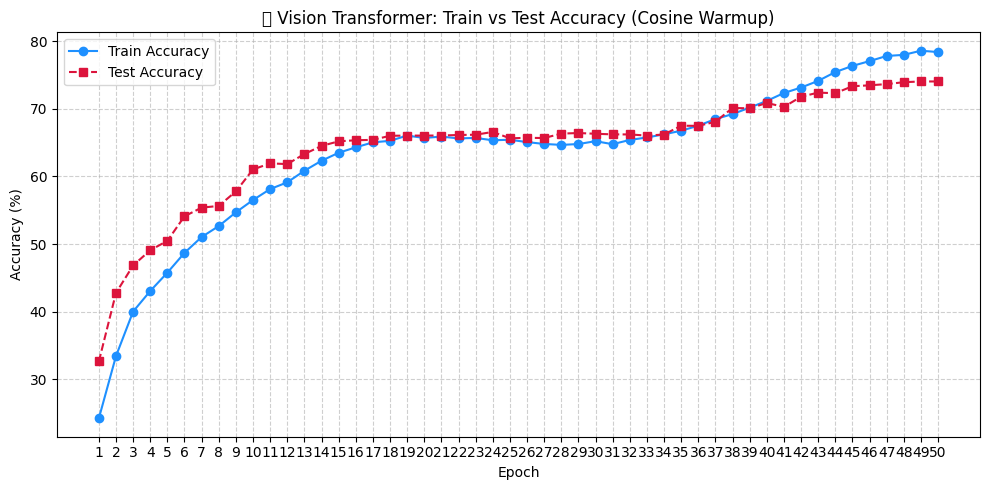

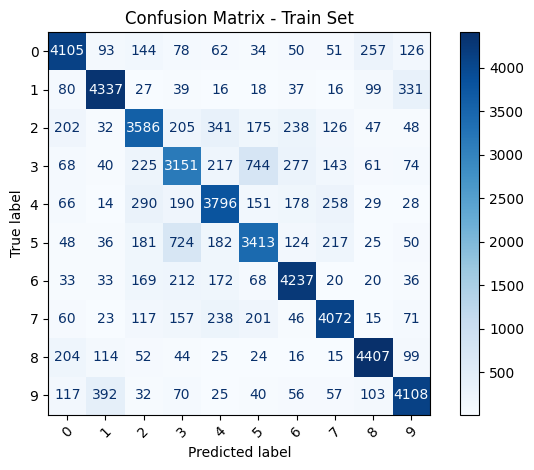

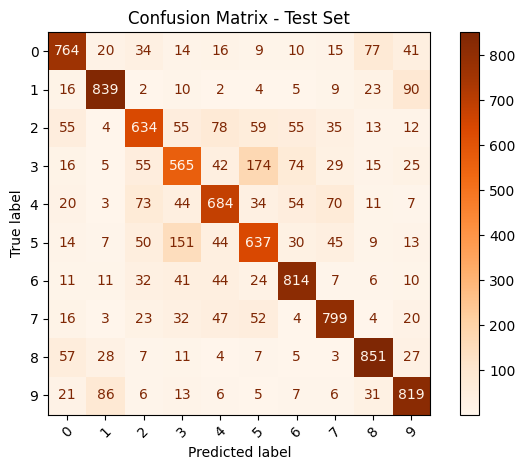

In [ ]:
torch.save(vit.state_dict(), "simple_vit_cifar10-cosine-warmup.pth")
print("✅ Model saved successfully.")

# ============================
# 📊 Accuracy Plot
# ============================
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_accuracies, marker='o', linestyle='-', label='Train Accuracy', color='dodgerblue')
plt.plot(range(1, NUM_EPOCHS + 1), test_accuracies, marker='s', linestyle='--', label='Test Accuracy', color='crimson')
plt.title('📊 Vision Transformer: Train vs Test Accuracy (Cosine Warmup)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, NUM_EPOCHS + 1))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/vit_cosine_warmup_accuracy_plot.png")
plt.show()

# ============================
# 🔍 Confusion Matrices
# ============================

def plot_confusion_matrix(loader, title, filename, cmap):
    vit.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            patches = patching(images)
            outputs = vit(patches)
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=cmap, xticks_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_confusion_matrix(train_loader, "Confusion Matrix - Train Set", "/content/drive/MyDrive/confusion_matrix_train_cosine.png", cmap='Blues')
plot_confusion_matrix(test_loader, "Confusion Matrix - Test Set", "/content/drive/MyDrive/confusion_matrix_test_cosine.png", cmap='Oranges')
